In [1]:
!pip install fxcmpy &> /dev/null
!pip install python-socketio==4.4 &> /dev/null
!pip install python-engineio==3.9 &> /dev/null
!pip install websocket-client==1.1.0 &> /dev/null
!pip install ipywidgets &> /dev/null
!pip install ta &> /dev/null


In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from pickle import load
from keras import callbacks

from ta.volatility import BollingerBands
from ta.momentum import stochrsi
from ta.utils import dropna

import fxcmpy
import socketio
import tensorflow as tf
import time

from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
def set_connection():
  """
  Set Connection function is for setting up our connection with the FXCM websocket.
  """
  TOKEN = 'c5dfc9467520b685d9da5970bedc8aece8384c61'
  con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error', server='demo', log_file='log.txt')
  return con

In [16]:
def set_Model(model_file = 'GRU_Trained (10k).h5'):
  """
  Selecting the weight files for GRU model being used in the ensemble.
  """
  G_model = tf.keras.models.load_model(model_file)
  return G_model


In [17]:
def get_Data(con):
  """
   Retrieving data based using the connection setup.
  """
  data = con.get_candles('USD/CAD', period='m1', number=199)
  df = pd.DataFrame()
  df['high'] = data['askhigh']
  df['low'] = data['asklow']
  df['open'] = data['askopen']
  df['close'] = data['askclose']
  return df

In [18]:
def ta(df):
  """
  Performing technical analysis on the data. Returns a dataframe appended 
  with indicator values for Bollinger bands and RSI.
  """
  indicator_bb = BollingerBands(close=df["close"], window=20, window_dev=2)
  df['bb_bbm'] = indicator_bb.bollinger_mavg()
  df['bb_bbh'] = indicator_bb.bollinger_hband()
  df['bb_bbl'] = indicator_bb.bollinger_lband()
  df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
  df['Stoch RSI'] = stochrsi(df['close'], window = 14)
  return df  

In [19]:
def preprocess_data(df_gru):
  """
  Preprocessing the dataframe into a numpy array. 
  """
  #df_gru = get_Data(con)
  dataset=df_gru.iloc[:-1,:]
  x = dataset.to_numpy()
  x = np.reshape(x, (496632,3,4))
  return x


In [20]:
def gru(x, model):
  """
  Predicting results based on GRU model. Returns difference between current price
  at current time instance t and future price predicted at time instance t+1.
  """
  res = model.predict(x)
  return x


In [21]:
def ta_short_sig(df):
  """
  Based on the TA indicator values Short Signal from each indicator is calculated.
  """
  RSI_Short_Sig = []
  BB_Short_Sig = []
  for i in range(len(list(df['Stoch RSI']))):
    if list(df['Stoch RSI'])[i] > 0.7:
      RSI_Short_Sig.append(int(1))
    else:
      RSI_Short_Sig.append(int(0))
    
    if list(df['close'] -  df['bb_bbh'])[0] > 0:
      BB_Short_Sig.append(int(1))
    else:
      BB_Short_Sig.append(int(0))

  df['RSI Short Signal'] = RSI_Short_Sig
  df['BB Short Signal'] = BB_Short_Sig
  new_df = df[['close','RSI Short Signal','BB Short Signal']]
  return new_df


In [22]:
def ta_long_sig(df):
  """
  Based on the TA indicator values Long Signal from each indicator is calculated.
  """
  RSI_Long_Sig = []
  BB_Long_Sig = []
  for i in range(len(list(df['Stoch RSI']))):
    if list(df['Stoch RSI'])[i] < 0.3:
      RSI_Long_Sig.append(int(1))
    else:
      RSI_Long_Sig.append(int(0))
    
    if list(df['bb_bbl'] - df['close'])[0] > 0:
      BB_Long_Sig.append(int(1))
    else:
      BB_Long_Sig.append(int(0))

  df['RSI Long Signal'] = RSI_Long_Sig
  df['BB Long Signal'] = BB_Long_Sig
  new_df = df[['close','RSI Long Signal','BB Long Signal']]
  return new_df


In [23]:
def final_sig(con):
  """
  Generating final signals for Long and Short positions.
  """
  pos1, RSI_Short_Sig, BB_Short_Sig = ta_short_sig(ta(get_Data(con))).iloc[-1][0], ta_short_sig(ta(get_Data(con))).iloc[-1][1], ta_short_sig(ta(get_Data(con))).iloc[-1][2]
  pos2, RSI_Long_Sig, BB_Long_Sig = ta_long_sig(ta(get_Data(con))).iloc[-1][0], ta_short_sig(ta(get_Data(con))).iloc[-1][1], ta_short_sig(ta(get_Data(con))).iloc[-1][2]
  return pos1, RSI_Short_Sig, BB_Short_Sig, pos2, RSI_Long_Sig, BB_Long_Sig

In [24]:
model = set_Model()

In [25]:
df = pd.read_csv("USDCAD5.csv", names=["date","time","open","high","low","close","not"])
df = df[["open","high","low","close"]]
df = df.iloc[5000:10001]

In [26]:
#df = pd.read_csv("DAT_MT_EURUSD_M1_2019.csv", names=["date","time","open","high","low","close","not"])
#df = df[["open","high","low","close"]]
#df = df.iloc[5000:10001]

In [27]:

x = df.to_numpy()
x = np.reshape(x, (1667,3,4))
x.shape[0]

1667

In [28]:
m = gru(x, model)

In [29]:
m = np.reshape(m, (5001,4))

In [30]:
gru_list = []
for i in range(len(m)):
  gru_list.append(m[i][0])

In [31]:
n = ta(df)

In [32]:
n['gru'] = gru_list

In [33]:
n.dropna(inplace =True)

In [34]:
ta_long = ta_long_sig(n)
ta_short = ta_short_sig(n)

In [35]:
ta_long['bb'] = n['close'] - n['bb_bbl']
ta_short['bb'] = n['bb_bbh'] - n['close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
for i in range(len(ta_long)):
  ta_long['gru'] = ta_long['close'] - n['gru']
  ta_short['gru'] = ta_short['close'] - n['gru']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
#With GRU
open = 0
long_profit = 0
long_loss = 0
net_long = []
for i in range(len(ta_long)):
  if open == 0:
    if list(ta_long['RSI Long Signal'])[i] == 1 and list(ta_long['bb'])[i] < 0 and list(ta_long['gru'])[i] <= 0:
      open = 1
      purchase = list(ta_long['close'])[i]
  if open == 1:
    if list(ta_long['close'])[i] - purchase < 0:
      net_long.append(list(ta_long['close'])[i] - purchase)
      long_profit += 1
      open = 0
    if list(ta_long['close'])[i] - purchase > 0:
      net_long.append(list(ta_long['close'])[i] - purchase)
      long_loss += 1
      open = 0

print(long_profit,long_loss)
print(long_profit/(long_profit+long_loss))
print(sum(net_long))

89 110
0.4472361809045226
0.0052300000000014


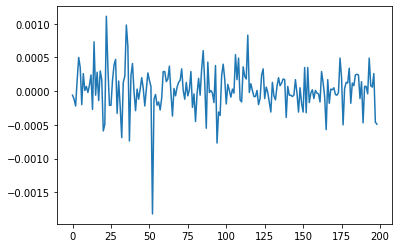

In [38]:
plt.plot(net_long)
plt.show()

In [39]:
#With GRU
open = 0
short_profit = 0
short_loss = 0
net_short = []
for i in range(len(ta_short)):
  if open == 0:
    if list(ta_short['RSI Short Signal'])[i] == 1 and list(ta_short['bb'])[i] > 0 and list(ta_short['gru'])[i] > 0:
      open = 1
      purchase = list(ta_short['close'])[i]
  if open == 1:
    if list(ta_short['close'])[i] - purchase < 0:
      net_short.append(list(ta_short['close'])[i] - purchase)
      short_profit += 1
      open = 0
    if list(ta_short['close'])[i] - purchase > 0:
      net_short.append(list(ta_short['close'])[i] - purchase
      short_loss += 1
      open = 0


print(short_profit,short_loss)
print(short_profit/(short_profit+short_loss))
print(sum(net_short))

348 318
0.5225225225225225
0.003959999999997521


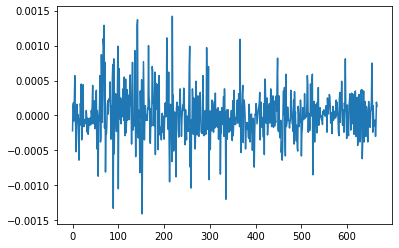

In [40]:
plt.plot(net_short)
plt.show()

In [47]:
#Without GRU
open = 0
long_profit = 0
long_loss = 0
net_long = []
for i in range(len(ta_long)):
  if open == 0:
    if list(ta_long['RSI Long Signal'])[i] == 1 and list(ta_long['bb'])[i] < 0:
      open = 1
      purchase = list(ta_long['close'])[i]
  if open == 1:
    if list(ta_long['close'])[i] - purchase < 0:
      net_long.append(list(ta_long['close'])[i] - purchase)
      long_profit += 1
      open = 0
    if list(ta_long['close'])[i] - purchase > 0:
      net_long.append(list(ta_long['close'])[i] - purchase)
      long_loss += 1
      open = 0

print('win/loss=',long_profit,long_loss)
print('winrate=',long_profit/(long_profit+long_loss))
print(sum(net_long))

win/loss= 89 112
winrate= 0.4427860696517413
0.005910000000001636


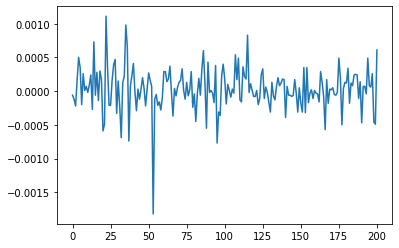

In [42]:
plt.plot(net_long)
plt.show()

In [43]:
#Without GRU
open = 0
short_profit = 0
short_loss = 0
net_short = []
for i in range(len(ta_short)):
  if open == 0:
    if list(ta_short['RSI Short Signal'])[i] == 1 and list(ta_short['bb'])[i] > 0 and list(ta_short['gru'])[i] > 0:
      open = 1
      purchase = list(ta_short['close'])[i]
  if open == 1:
    if list(ta_short['close'])[i] - purchase < 0:
      net_short.append(list(ta_short['close'])[i] - purchase)
      short_profit += 1
      open = 0
    if list(ta_short['close'])[i] - purchase > 0:
      net_short.append(list(ta_short['close'])[i] - purchase)
      short_loss += 1
      open = 0


print(short_profit,short_loss)
print(short_profit/(short_profit+short_loss))
print(sum(net_short))

348 318
0.5225225225225225
0.003959999999997521


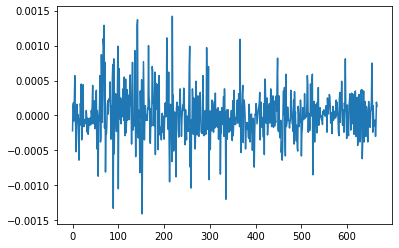

In [44]:
plt.plot(net_short)
plt.show()